# <span style="color:#bce35b;font-size:35px"><b>Project</b></span>
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<span style="color:#8c8c8c">Patrick Weatherford</span><br>
<span style="color:#8c8c8c">DSC 540 - Data Preparation</span>

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

***

<br>

<span style="font-size:18px"><b>Overview</b>:

For this project, I'll be obtaining, joining, and visualizing data by country/year for cancer mortality, sun duration time, and observed solar cycle information. 

***

<br>

<span style="font-size:18px"><b>Import Libraries</b>:

In [1]:
import os
import keyring

# manually set environment variables for kaggle api to download straight from Python to current directory
os.environ["KAGGLE_USERNAME"] = "hakunapatata"
os.environ["KAGGLE_KEY"] = keyring.get_password(
    service_name="kaggle_api", username=os.environ["KAGGLE_USERNAME"]
)

from collections import deque
from http.client import responses
import requests
from bs4 import BeautifulSoup as BS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz, process
# import kaggle
import sqlite3

# matplotlib default settings
plt.style.use("dark_background")
mpl.rcParams.update({"lines.linewidth": 3})
mpl.rcParams.update({"axes.labelsize": 14})
mpl.rcParams.update({"axes.titlesize": 16})
mpl.rcParams.update({"axes.titleweight": "bold"})
mpl.rcParams.update({"figure.autolayout": True})
mpl.rcParams.update(
    {"axes.grid": True, "grid.color": "#424242", "grid.linestyle": "--"}
)

#global variables
db_path='HakunaPatata.db'


<br>

<span style="font-size:18px"><b>Custom Functions/Classes</b>:

In [2]:
## function to take DB/SQL and create a pandas DataFrame from the dataset returned.
def sql_to_df(db_path, sql_txt):

    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(sql_txt, conn)
        return df
    conn.close()


## function to take dataframe and create SQLite 
def df_to_sqlite(df, db_path, table_name, index=False, if_exists='replace', chunksize=5000):
    df.to_sql(name=table_name, con=f"sqlite:///{db_path}", index=index, if_exists=if_exists, chunksize=chunksize)


## function to show all custom tables in SQLite DB
def sqlite_tables(db_path):
    sql_txt = r"SELECT name AS TABLE_NAME FROM sqlite_schema WHERE type='table' AND name NOT LIKE 'sqlite_%'"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(sql_txt, conn)
        return df
    conn.close()


## function to drop table from SQLite DB
def sqlite_drop_table(db_path, table_name):
    sql_txt = f'DROP TABLE IF EXISTS {table_name}'
    with sqlite3.connect(db_path) as conn:
        conn.execute(sql_txt)
    conn.close()



<br>

***

# <span style="color:#bce35b">Data Sets</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

<span style="font-size:18px"><b>Overview</b>:

For this project, there are 3 different datasets required which must come from different sources. One source via a flat file download, another source from web scraping, and a final source from an API call. The final dataset must have at least 1000 observations. 
    
After reviewing datasets from multiple different sources, I ran across a dataset which has cancer death totals by country/city/year. One of the columns had total deaths from malignant skin melanoma which caught my attention due to multiple members of my family passing away from this type of cancer and the fact that as of this writing, I’m severely sunburned from a recent fishing expedition. From here, I began to hypothesize that peak solar cycles and sun duration by country may have an effect on the total amount of deaths due to malignant skin melanoma. Who knows, maybe it has an effect on all types of cancer. At this point I searched and found 2 more datasets which I could use to join onto the cancer mortality dataset. One found on Wikipedia which had sun duration times by country/city/month and the other found on NOAA (National Oceanic and Atmospheric Administration) which had historical solar cycle information. 
    
If strong correlation was found with cancer deaths, high solar durations, and periods of solar maximums, more awareness could be raised to warn the public and potentially reduce the number of cancer deaths. 
Depending on the dataset, I’ll either be joining based on the country name or year. One potential challenge I see when joining the data by country would be the fact that each data source may have different spellings for each country or may incorporate different capitalizations which will need to be handled.  


## <span style="color:#ae8bd5">Flat File</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

This dataset contains total cancer deaths by country/year and cancer type.<br>
[https://www.kaggle.com/datasets/bahadirumutiscimen/cancer-death-rates-in-the-world-19902019?select=total-cancer-deaths-by-type.csv](https://www.kaggle.com/datasets/bahadirumutiscimen/cancer-death-rates-in-the-world-19902019?select=total-cancer-deaths-by-type.csv)

In [3]:
# dataset = "bahadirumutiscimen/cancer-death-rates-in-the-world-19902019"
file_name = "total-cancer-deaths-by-type.csv"

# kaggle.api.dataset_download_file(
#     dataset=dataset, file_name=file_name, quiet=True)


cancer_df = pd.read_csv(file_name + ".zip")


In [4]:
cancer_df


,Entity,Code,Year,Deaths - Liver cancer - Sex: Both - Age: All Ages (Number),Deaths - Kidney cancer - Sex: Both - Age: All Ages (Number),Deaths - Lip and oral cavity cancer - Sex: Both - Age: All Ages (Number),"Deaths - Tracheal, bronchus, and lung cancer - Sex: Both - Age: All Ages (Number)",Deaths - Larynx cancer - Sex: Both - Age: All Ages (Number),Deaths - Gallbladder and biliary tract cancer - Sex: Both - Age: All Ages (Number),Deaths - Malignant skin melanoma - Sex: Both - Age: All Ages (Number),...,Deaths - Brain and central nervous system cancer - Sex: Both - Age: All Ages (Number),Deaths - Non-Hodgkin lymphoma - Sex: Both - Age: All Ages (Number),Deaths - Pancreatic cancer - Sex: Both - Age: All Ages (Number),Deaths - Esophageal cancer - Sex: Both - Age: All Ages (Number),Deaths - Testicular cancer - Sex: Both - Age: All Ages (Number),Deaths - Nasopharynx cancer - Sex: Both - Age: All Ages (Number),Deaths - Other pharynx cancer - Sex: Both - Age: All Ages (Number),Deaths - Colon and rectum cancer - Sex: Both - Age: All Ages (Number),Deaths - Non-melanoma skin cancer - Sex: Both - Age: All Ages (Number),Deaths - Mesothelioma - Sex: Both - Age: All Ages (Number)
0,Afghanistan,AFG,1990,851,66,89,983,260,180,47,...,422,996,138,529,3,66,37,539,25,6
1,Afghanistan,AFG,1991,866,66,89,982,263,182,48,...,438,1010,137,535,4,67,37,542,26,7
2,Afghanistan,AFG,1992,890,68,91,989,268,185,51,...,472,1040,137,546,4,69,38,550,26,7
3,Afghanistan,AFG,1993,914,70,93,995,275,189,53,...,505,1062,139,560,5,72,39,555,27,7
4,Afghanistan,AFG,1994,933,71,94,996,282,193,54,...,526,1069,140,575,5,73,39,554,28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,948,59,145,902,149,87,125,...,104,96,426,988,11,53,40,719,39,16
8006,Zimbabwe,ZWE,2016,966,61,150,932,153,89,129,...,109,100,449,1012,11,54,42,744,40,17
8007,Zimbabwe,ZWE,2017,982,63,154,960,156,91,133,...,112,102,471,1035,12,56,43,767,41,17
8008,Zimbabwe,ZWE,2018,998,66,159,993,160,92,137,...,115,105,495,1059,12,57,44,792,43,17


<br>
<u>Step#1</u><br>
Rename headers.

In [5]:
# Cleaninig column names

new_cols = [
    "COUNTRY_ENTITY",
    "COUNTRY_CODE",
    "YEAR",
    "LIVER_CANCER_DEATHS",
    "KIDNEY_CANCER_DEATHS",
    "LIP_ORAL_CANCER_DEATHS",
    "TRACHEAL_BRONCHUS_LUNG_CANCER_DEATHS",
    "LARYNX_CANCER_DEATHS",
    "GALLBLADDER_BILIARY_CANCER_DEATHS",
    "MELANOMA_SKIN_CANCER_DEATHS",
    "LEUKEMIA_DEATHS",
    "HODGKIN_LYMPHOMA_DEATHS",
    "MULTIPLE_MYELOMA_DEATHS",
    "OTHER_NEOPLASM_DEATHS",
    "BREAST_CANCER_DEATHS",
    "PROSTATE_CANCER_DEATHS",
    "THYROID_CANCER_DEATHS",
    "STOMACH_CANCER_DEATHS",
    "BLADDER_CANCER_DEATHS",
    "UTERINE_CANCER_DEATHS",
    "OVARIAN_CANCER_DEATHS",
    "CERVICAL_CANCER_DEATHS",
    "BRAIN_CNS_CANCER_DEATHS",
    "NON-HODGKIN_LYMPHOMA_DEATHS",
    "PANCREATIC_CANCER_DEATHS",
    "ESOPHAGEAL_CANCER_DEATHS",
    "TESTICULAR_CANCER_DEATHS",
    "NASOPHARYNX_CANCER_DEATHS",
    "OTHER_PHARYNX_CANCER_DEATHS",
    "COLON_RECTUM_CANCER_DEATHS",
    "NON-MELANOMA_SKIN_CANCER_DEATHS",
    "MESOTHELIOMA_DEATHS",
]

cancer_df.columns = new_cols


In [6]:
cancer_df


,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,LIVER_CANCER_DEATHS,KIDNEY_CANCER_DEATHS,LIP_ORAL_CANCER_DEATHS,TRACHEAL_BRONCHUS_LUNG_CANCER_DEATHS,LARYNX_CANCER_DEATHS,GALLBLADDER_BILIARY_CANCER_DEATHS,MELANOMA_SKIN_CANCER_DEATHS,...,BRAIN_CNS_CANCER_DEATHS,NON-HODGKIN_LYMPHOMA_DEATHS,PANCREATIC_CANCER_DEATHS,ESOPHAGEAL_CANCER_DEATHS,TESTICULAR_CANCER_DEATHS,NASOPHARYNX_CANCER_DEATHS,OTHER_PHARYNX_CANCER_DEATHS,COLON_RECTUM_CANCER_DEATHS,NON-MELANOMA_SKIN_CANCER_DEATHS,MESOTHELIOMA_DEATHS
0,Afghanistan,AFG,1990,851,66,89,983,260,180,47,...,422,996,138,529,3,66,37,539,25,6
1,Afghanistan,AFG,1991,866,66,89,982,263,182,48,...,438,1010,137,535,4,67,37,542,26,7
2,Afghanistan,AFG,1992,890,68,91,989,268,185,51,...,472,1040,137,546,4,69,38,550,26,7
3,Afghanistan,AFG,1993,914,70,93,995,275,189,53,...,505,1062,139,560,5,72,39,555,27,7
4,Afghanistan,AFG,1994,933,71,94,996,282,193,54,...,526,1069,140,575,5,73,39,554,28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,948,59,145,902,149,87,125,...,104,96,426,988,11,53,40,719,39,16
8006,Zimbabwe,ZWE,2016,966,61,150,932,153,89,129,...,109,100,449,1012,11,54,42,744,40,17
8007,Zimbabwe,ZWE,2017,982,63,154,960,156,91,133,...,112,102,471,1035,12,56,43,767,41,17
8008,Zimbabwe,ZWE,2018,998,66,159,993,160,92,137,...,115,105,495,1059,12,57,44,792,43,17


<br>

For this analysis, I will be looking at skin cancer deaths and total cancer deaths per country/year. Will need to sum numerical values horizonatally (excluding year).

<u>Step#2</u><br>
Create Melanoma skin cancer deaths by Country/Year

<u>Step#3</u><br>
Create Non-Melanoma skin cancer deaths by Country/Year

<u>Step#4</u><br>
Create Total Non-Melanoma + Melanoma skin cancer deaths by Country/Year.

<u>Step#5</u><br>
Drop columns that are no longer needed.

In [7]:
total_list = list(cancer_df.columns)  # make list of DF columns
total_list = [
    e
    for e in total_list
    if e
    not in (
        "COUNTRY_ENTITY",
        "COUNTRY_CODE",
        "YEAR",
    )  # pick out columns that will not be used in summation
]

skin_total_list = [
    "MELANOMA_SKIN_CANCER_DEATHS",
    "NON-MELANOMA_SKIN_CANCER_DEATHS",
]  # columns to use for skin cancer deaths

cancer_df["TOTAL_CANCER_DEATHS"] = cancer_df[total_list].sum(
    axis=1
)  # sum DF horizontally

cancer_df["SKIN_CANCER_DEATHS"] = cancer_df[skin_total_list].sum(
    axis=1
)  # sum DF horizontally

cancer_df = cancer_df[  # select desired columns
    [
        "COUNTRY_ENTITY",
        "COUNTRY_CODE",
        "YEAR",
        "SKIN_CANCER_DEATHS",
        "TOTAL_CANCER_DEATHS",
    ]
]

cancer_df


,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,SKIN_CANCER_DEATHS,TOTAL_CANCER_DEATHS
0,Afghanistan,AFG,1990,72,10386
1,Afghanistan,AFG,1991,74,10558
2,Afghanistan,AFG,1992,77,10894
3,Afghanistan,AFG,1993,80,11241
4,Afghanistan,AFG,1994,82,11484
...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,164,10735
8006,Zimbabwe,ZWE,2016,169,11028
8007,Zimbabwe,ZWE,2017,174,11291
8008,Zimbabwe,ZWE,2018,180,11575


<br>

Import DataFrame to SQLite table.

In [8]:
df_to_sqlite(df=cancer_df, db_path=db_path, table_name='COUNTRY_YEAR_CANCER_DEATHS')

sql_txt = r'''
SELECT CYCD.*
FROM COUNTRY_YEAR_CANCER_DEATHS CYCD
LIMIT 5
'''
sql_to_df(db_path=db_path, sql_txt=sql_txt)

,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,SKIN_CANCER_DEATHS,TOTAL_CANCER_DEATHS
0,Afghanistan,AFG,1990,72,10386
1,Afghanistan,AFG,1991,74,10558
2,Afghanistan,AFG,1992,77,10894
3,Afghanistan,AFG,1993,80,11241
4,Afghanistan,AFG,1994,82,11484


<br>

## <span style="color:#ae8bd5">Web Scraping</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

This dataset contains solar duration times by country/city/month.<br>
[https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration](https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration)

In [9]:
# use requests package to GET url data and check if successful
url = "https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration"
r = requests.get(url)
r_status = responses[r.status_code]

print(f"GET request status code: {r_status} [{r.status_code}]")


GET request status code: OK [200]


In [10]:
# use BeautifulSoup package to find wikipedia tables on page
soup = BS(r.text, "html.parser")

wiki_table_find = soup.find_all("table", {"class": "wikitable"})


In [11]:
# convert found class HTML elements that match criteria, convert to string, then read with pandas into a DataFrame
wiki_tables = pd.read_html(str(wiki_table_find))

# concat (aka union) multiple tables found
solar_time_df = pd.concat(wiki_tables)


In [12]:
solar_time_df


,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,Ref.
0,Ivory Coast,Gagnoa,183.0,180.0,196.0,188.0,181.0,118.0,97.0,80.0,110.0,155.0,171.0,164.0,1823.0,[2]
1,Ivory Coast,Bouaké,242.0,224.0,219.0,194.0,208.0,145.0,104.0,82.0,115.0,170.0,191.0,198.0,2092.0,[2]
2,Ivory Coast,Abidjan,223.0,223.0,239.0,214.0,205.0,128.0,137.0,125.0,139.0,215.0,224.0,224.0,2296.0,[2]
3,Ivory Coast,Odienné,242.0,220.2,217.3,214.7,248.8,221.8,183.5,174.5,185.4,235.8,252.0,242.6,2638.6,[3]
4,Ivory Coast,Ferké,279.0,249.0,253.0,229.0,251.0,221.0,183.0,151.0,173.0,245.0,261.0,262.0,2757.0,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,New Zealand,Christchurch,224.4,190.5,177.4,155.6,133.3,117.7,124.8,149.0,166.6,201.3,215.3,214.3,2070.2,?
18,New Zealand,Wellington,240.3,205.0,194.7,153.8,126.0,102.3,111.4,137.2,163.2,191.1,210.8,222.9,2058.7,?
19,New Zealand,Auckland,228.8,194.9,189.2,157.3,139.8,110.3,128.1,142.9,148.6,178.1,188.1,197.2,2003.1,?
20,Fiji,Suva,192.2,178.0,170.5,153.0,145.7,141.0,136.4,142.6,135.0,164.3,168.0,195.3,1922.0,[191]


<br>

Don't really care about city since it is not in all the datasets. Will group by country to get the average sunlight hours in a year for each country. I also don't like the total sunlight hours per year being call just 'Year'. This is confusing and makes it seem like we're looking at calendar years. Will rename the column.

<u>Step#1</u><br>
Group by country and get the average sunlight hours per Country/Year.

<u>Step#2</u><br>
Rename columns.

<u>Step#3</u><br>
Reindex the DataFrame by Country.

In [13]:
solar_time_df = solar_time_df.groupby(["Country"]).mean()

# only select the averaged 'year' column
solar_time_df = solar_time_df[["Year"]]

solar_time_df.columns = ["AVG_SUNLIGHT_HRS_IN_YEAR"]  # rename 'year' column

solar_time_df.index.names = ["COUNTRY"]  # rename index

solar_time_df


,AVG_SUNLIGHT_HRS_IN_YEAR
COUNTRY,
Afghanistan,3175.100000
Albania,2544.000000
Algeria,3266.500000
Angola,2341.000000
Argentina,2220.300000
...,...
Uzbekistan,2823.900000
Venezuela,2895.300000
Vietnam,2123.500000


<br>

<u>Step#4</u><br>
Create a column for the overall standard deviation total sunlight hrs per country/year.

In [14]:
solar_time_df['OVERALL_SUNLIGHT_HRS_STD'] = solar_time_df['AVG_SUNLIGHT_HRS_IN_YEAR'].std()

solar_time_df

,AVG_SUNLIGHT_HRS_IN_YEAR,OVERALL_SUNLIGHT_HRS_STD
COUNTRY,,
Afghanistan,3175.100000,593.269953
Albania,2544.000000,593.269953
Algeria,3266.500000,593.269953
Angola,2341.000000,593.269953
Argentina,2220.300000,593.269953
...,...,...
Uzbekistan,2823.900000,593.269953
Venezuela,2895.300000,593.269953
Vietnam,2123.500000,593.269953


<br>

<u>Step#5</u><br>
Get the overall mean sunlight hours per country/year.

In [15]:
solar_time_df['OVERALL_SUNLIGHT_HRS_MEAN'] = solar_time_df['AVG_SUNLIGHT_HRS_IN_YEAR'].mean()

solar_time_df

,AVG_SUNLIGHT_HRS_IN_YEAR,OVERALL_SUNLIGHT_HRS_STD,OVERALL_SUNLIGHT_HRS_MEAN
COUNTRY,,,
Afghanistan,3175.100000,593.269953,2442.228314
Albania,2544.000000,593.269953,2442.228314
Algeria,3266.500000,593.269953,2442.228314
Angola,2341.000000,593.269953,2442.228314
Argentina,2220.300000,593.269953,2442.228314
...,...,...,...
Uzbekistan,2823.900000,593.269953,2442.228314
Venezuela,2895.300000,593.269953,2442.228314
Vietnam,2123.500000,593.269953,2442.228314


<br>

Import data into SQLite table.

In [16]:
df_to_sqlite(df=solar_time_df, db_path=db_path, table_name='COUNTRY_SUN_HRS', index=True)

sql_txt = r'''
SELECT CSH.*
FROM COUNTRY_SUN_HRS CSH
LIMIT 5
'''
sql_to_df(db_path=db_path, sql_txt=sql_txt)

,COUNTRY,AVG_SUNLIGHT_HRS_IN_YEAR,OVERALL_SUNLIGHT_HRS_STD,OVERALL_SUNLIGHT_HRS_MEAN
0,Afghanistan,3175.1,593.269953,2442.228314
1,Albania,2544.0,593.269953,2442.228314
2,Algeria,3266.5,593.269953,2442.228314
3,Angola,2341.0,593.269953,2442.228314
4,Argentina,2220.3,593.269953,2442.228314


<br>

## <span style="color:#ae8bd5">API</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

This dataset contains solar cycle information.<br>
[https://www.swpc.noaa.gov/products/solar-cycle-progression](https://www.swpc.noaa.gov/products/solar-cycle-progression)

In [17]:
url = (
    "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
)

r = requests.get(url).json()

solar_cycle_df = pd.DataFrame(r)


In [18]:
solar_cycle_df


,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.00,-1.0,-1.00,-1.0
1,1749-02,104.3,-1.0,-1.00,-1.0,-1.00,-1.0
2,1749-03,116.7,-1.0,-1.00,-1.0,-1.00,-1.0
3,1749-04,92.8,-1.0,-1.00,-1.0,-1.00,-1.0
4,1749-05,141.7,-1.0,-1.00,-1.0,-1.00,-1.0
...,...,...,...,...,...,...,...
3275,2021-12,67.5,-1.0,69.42,-1.0,102.94,-1.0
3276,2022-01,54.0,-1.0,56.97,-1.0,104.05,-1.0
3277,2022-02,59.7,-1.0,65.61,-1.0,109.15,-1.0
3278,2022-03,78.5,-1.0,69.06,-1.0,117.79,-1.0


<br>

<u>Step#1</u><br>
Remove unnecessary columns.

<u>Step#2</u><br>
Rename columns.

In [19]:
# pick off desired columns
solar_cycle_df = solar_cycle_df[["time-tag", "ssn"]]

new_cols = ["YEAR", "SUNSPOT_COUNT"]  # name for new columns

solar_cycle_df.columns = new_cols

solar_cycle_df


,YEAR,SUNSPOT_COUNT
0,1749-01,96.7
1,1749-02,104.3
2,1749-03,116.7
3,1749-04,92.8
4,1749-05,141.7
...,...,...
3275,2021-12,67.5
3276,2022-01,54.0
3277,2022-02,59.7
3278,2022-03,78.5


<br>

<u>Step#3</u><br>
Remove the month portion of the year so that I can group by year.

In [20]:
# now to format and group by the year column
solar_cycle_df["YEAR"].replace("-.+", "", regex=True, inplace=True)

solar_cycle_df


C:\Users\patwea\AppData\Local\Temp\ipykernel_5276\591867914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_cycle_df["YEAR"].replace("-.+", "", regex=True, inplace=True)


,YEAR,SUNSPOT_COUNT
0,1749,96.7
1,1749,104.3
2,1749,116.7
3,1749,92.8
4,1749,141.7
...,...,...
3275,2021,67.5
3276,2022,54.0
3277,2022,59.7
3278,2022,78.5


<br>

<u>Step#4</u><br>
Check to see if 'Year' column can be converted to a number and if so, convert to number.

In [21]:
# see if any year numbers do not equal 4 numbers
len(solar_cycle_df[solar_cycle_df["YEAR"].str.len() != 4])


0

In [22]:
# see if there are any years that are non-numeric
len(solar_cycle_df["YEAR"]) - sum(solar_cycle_df["YEAR"].str.isnumeric())


0

In [23]:
try:
    solar_cycle_df["YEAR"] = solar_cycle_df["YEAR"].astype(int)

except Exception as error:
    print(f"{error.__class__.__name__} exception raised! Datatype not converted!")


solar_cycle_df["YEAR"].dtype


C:\Users\patwea\AppData\Local\Temp\ipykernel_5276\2669255454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_cycle_df["YEAR"] = solar_cycle_df["YEAR"].astype(int)


dtype('int32')

<br>

<u>Step#5</u><br>
Group by year and create column that sums to get the total number of sunspots per year.

In [24]:
# group by year and sum the sunspot counts in the months
solar_cycle_df = solar_cycle_df.groupby("YEAR").sum()

solar_cycle_df


,SUNSPOT_COUNT
YEAR,
1749,1618.5
1750,1668.0
1751,953.3
1752,956.0
1753,613.5
...,...
2018,84.1
2019,43.0
2020,105.5


<br>

Import data into SQLite table.

In [25]:
df_to_sqlite(df=solar_cycle_df, db_path=db_path, table_name='SUNSPOTS', index=True)

sql_txt = r'''
SELECT SS.*
FROM SUNSPOTS SS
LIMIT 5
'''
sql_to_df(db_path=db_path, sql_txt=sql_txt)

,YEAR,SUNSPOT_COUNT
0,1749,1618.5
1,1750,1668.0
2,1751,953.3
3,1752,956.0
4,1753,613.5


<br>

***

# <span style="color:#bce35b">Joining Datasets</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

<br>

Looking at all custom tables in SQLite DB.

Disregard MET_MUSEUM. That was for a previous assignment in this class :)

In [26]:
sqlite_tables(db_path=db_path)

,TABLE_NAME
0,PATIENT
1,MET_MUSEUM
2,COUNTRY_YEAR_CANCER_DEATHS
3,COUNTRY_SUN_HRS
4,SUNSPOTS


<br>

Joining Cancer DataFrame with Solar Cycle DataFrame. Starting with the cancer DataFrame and left joining onto the Solar Cycle DataFrame will remove the years that are not in the Solar Cycle DataFrame.

In [27]:
final_df = cancer_df.merge(solar_cycle_df, left_on='YEAR', right_index=True)

final_df


,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,SKIN_CANCER_DEATHS,TOTAL_CANCER_DEATHS,SUNSPOT_COUNT
0,Afghanistan,AFG,1990,72,10386,2296.7
30,Africa,NaN,1990,2570,279221,2296.7
60,African Region,NaN,1990,2259,230359,2296.7
90,African Union,NaN,1990,2570,279221,2296.7
120,Albania,ALB,1990,42,2428,2296.7
...,...,...,...,...,...,...
7889,World Bank Lower Middle Income,NaN,2019,16835,2117747,43.0
7919,World Bank Upper Middle Income,NaN,2019,45854,4170763,43.0
7949,Yemen,YEM,2019,108,11884,43.0
7979,Zambia,ZMB,2019,114,8845,43.0


<br>

Left joining the Solar Time DataFrame onto the above DataFrame. Will do fuzzy matching since country names may have different representations.


In [28]:
def fuzzy_match_df(col1, col2, threshold=90, fuzz_type='token_sort_ratio'):

    # get unique values from columns passed to function
    col1 = pd.Series(col1).unique()
    col2 = pd.Series(col2).unique()

    matches = []

    for c1 in col1:
        match = process.extractOne(c1, col2, scorer=getattr(
            fuzz, fuzz_type), score_cutoff=threshold)  # gets the best match above threshold
        if match is None:
            match_tuple = (c1, None)
        else:
            match_tuple = (c1, match[0])

        matches.append(match_tuple)
    return pd.DataFrame(matches, columns=['COL1', 'COL2_MATCH'])


In [29]:
# create intermediate fuzzy matching DataFrame
match_df = fuzzy_match_df(
    col1=final_df['COUNTRY_ENTITY'], col2=solar_time_df.index.values, threshold=91, fuzz_type='token_sort_ratio')

match_df


,COL1,COL2_MATCH
0,Afghanistan,Afghanistan
1,Africa,None
2,African Region,None
3,African Union,None
4,Albania,Albania
...,...,...
262,World Bank Lower Middle Income,None
263,World Bank Upper Middle Income,None
264,Yemen,None
265,Zambia,Zambia


In [30]:
# join data with intermediate fuzzy matching DataFrame
final_df = final_df.merge(match_df, how='inner',
                          left_on='COUNTRY_ENTITY', right_on='COL1')

final_df = final_df.merge(solar_time_df, how='inner',
                          left_on='COL2_MATCH', right_index=True)

final_df


,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,SKIN_CANCER_DEATHS,TOTAL_CANCER_DEATHS,SUNSPOT_COUNT,COL1,COL2_MATCH,AVG_SUNLIGHT_HRS_IN_YEAR,OVERALL_SUNLIGHT_HRS_STD,OVERALL_SUNLIGHT_HRS_MEAN
0,Afghanistan,AFG,1990,72,10386,2296.7,Afghanistan,Afghanistan,3175.1,593.269953,2442.228314
1,Afghanistan,AFG,1991,74,10558,2440.9,Afghanistan,Afghanistan,3175.1,593.269953,2442.228314
2,Afghanistan,AFG,1992,77,10894,1600.1,Afghanistan,Afghanistan,3175.1,593.269953,2442.228314
3,Afghanistan,AFG,1993,80,11241,916.2,Afghanistan,Afghanistan,3175.1,593.269953,2442.228314
4,Afghanistan,AFG,1994,82,11484,538.4,Afghanistan,Afghanistan,3175.1,593.269953,2442.228314
...,...,...,...,...,...,...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,164,10735,837.4,Zimbabwe,Zimbabwe,3065.4,593.269953,2442.228314
8006,Zimbabwe,ZWE,2016,169,11028,477.9,Zimbabwe,Zimbabwe,3065.4,593.269953,2442.228314
8007,Zimbabwe,ZWE,2017,174,11291,261.8,Zimbabwe,Zimbabwe,3065.4,593.269953,2442.228314
8008,Zimbabwe,ZWE,2018,180,11575,84.1,Zimbabwe,Zimbabwe,3065.4,593.269953,2442.228314


<br>

Lets clean up the final DataFrame columns

In [31]:
final_df = final_df[['COUNTRY_ENTITY', 'YEAR', 'SKIN_CANCER_DEATHS',
                     'TOTAL_CANCER_DEATHS', 'SUNSPOT_COUNT', 'AVG_SUNLIGHT_HRS_IN_YEAR']]

# viola, all the data is joined together!
final_df


,COUNTRY_ENTITY,YEAR,SKIN_CANCER_DEATHS,TOTAL_CANCER_DEATHS,SUNSPOT_COUNT,AVG_SUNLIGHT_HRS_IN_YEAR
0,Afghanistan,1990,72,10386,2296.7,3175.1
1,Afghanistan,1991,74,10558,2440.9,3175.1
2,Afghanistan,1992,77,10894,1600.1,3175.1
3,Afghanistan,1993,80,11241,916.2,3175.1
4,Afghanistan,1994,82,11484,538.4,3175.1
...,...,...,...,...,...,...
8005,Zimbabwe,2015,164,10735,837.4,3065.4
8006,Zimbabwe,2016,169,11028,477.9,3065.4
8007,Zimbabwe,2017,174,11291,261.8,3065.4
8008,Zimbabwe,2018,180,11575,84.1,3065.4


<br>

***

# <span style="color:#bce35b">Visualizing Data</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

<br>

Trending by Year: Total Skin Cancer Deaths vs. Sunspot Count

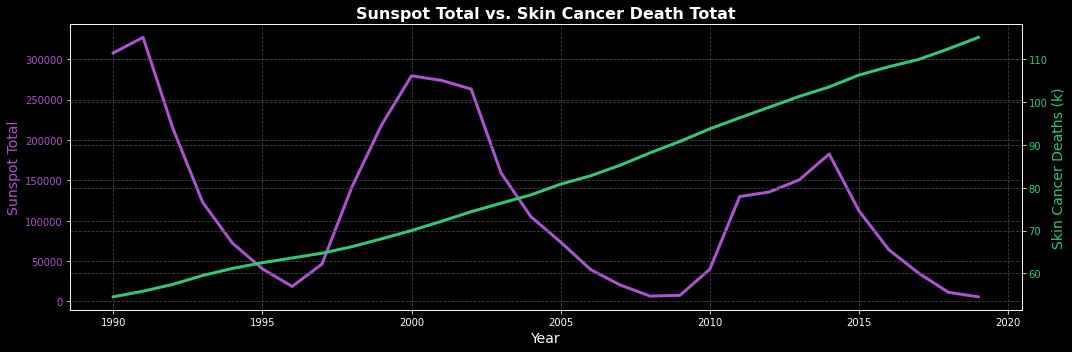

In [32]:
plot_data = final_df[['YEAR','SKIN_CANCER_DEATHS','SUNSPOT_COUNT']].groupby('YEAR').sum()

plt.figure(figsize=(15, 5))
plt.xlabel('Year')
ax = plt.gca()  # create axis object for plot
ax2 = ax.twinx()  # synchronize 2nd axis

ax.plot(plot_data.index.values,
        plot_data["SUNSPOT_COUNT"], c='#ad52d1', label='Solar Cycle')
ax.set_ylabel('Sunspot Total', c='#ad52d1')
ax.tick_params(axis='y', labelcolor='#ad52d1')

ax2.plot(plot_data.index.values,
         plot_data['SKIN_CANCER_DEATHS']/1000, c='#30c975', label='Skin Cancer Deaths')
ax2.set_ylabel('Skin Cancer Deaths (k)', c='#30c975')
ax2.tick_params(axis='y', labelcolor='#30c975')

plt.title('Sunspot Total vs. Skin Cancer Death Totat')
plt.show()


<br>

Scatterplot of Sunlight Hrs per County vs. Avg. Skin Cancer Deaths per Year

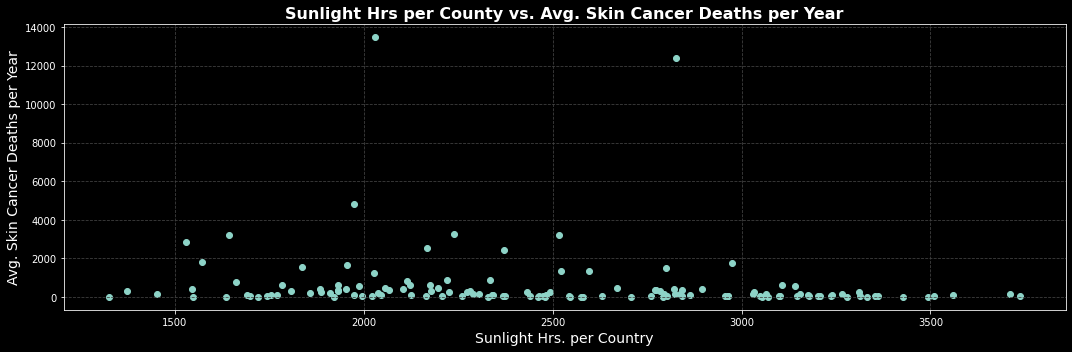

In [33]:
plot_data1 = final_df[['COUNTRY_ENTITY','AVG_SUNLIGHT_HRS_IN_YEAR']].groupby('COUNTRY_ENTITY').max()

plot_data2 = final_df[['COUNTRY_ENTITY','SKIN_CANCER_DEATHS']].groupby('COUNTRY_ENTITY').mean()

plot_data = plot_data1.merge(plot_data2, how='inner', left_index=True, right_index=True)

plt.figure(figsize=(15, 5))

plt.scatter(x=plot_data['AVG_SUNLIGHT_HRS_IN_YEAR'],y=plot_data['SKIN_CANCER_DEATHS'])
plt.xlabel('Sunlight Hrs. per Country')
plt.ylabel('Avg. Skin Cancer Deaths per Year')
plt.title('Sunlight Hrs per County vs. Avg. Skin Cancer Deaths per Year')
plt.show()

<br>

Boxplot of Avg. Skin Cancer Deaths per Country/Year.

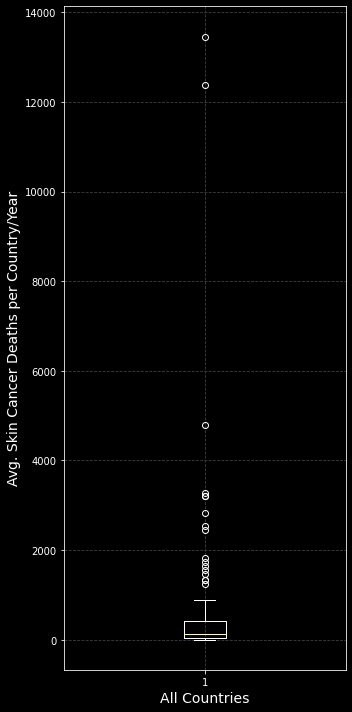

,SKIN_CANCER_DEATHS
count,134.000000
mean,611.570398
std,1705.177497
min,1.633333
25%,35.225000
50%,126.633333
75%,408.466667
max,13460.133333


In [34]:
plot_data = final_df[['COUNTRY_ENTITY','SKIN_CANCER_DEATHS']].groupby('COUNTRY_ENTITY').mean()

plt.figure(figsize=(5, 10))
plt.boxplot(plot_data['SKIN_CANCER_DEATHS'])
plt.xlabel('All Countries')
plt.ylabel('Avg. Skin Cancer Deaths per Country/Year')
plt.show()

plot_data.describe()

<br>

Top 15 Countries based on total skin cancer deaths.

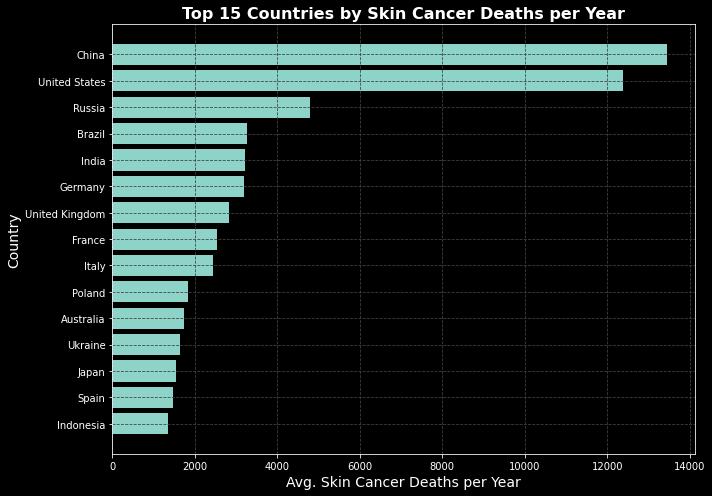

In [35]:
plot_data = final_df[['COUNTRY_ENTITY','SKIN_CANCER_DEATHS']].groupby('COUNTRY_ENTITY').mean().sort_values(by='SKIN_CANCER_DEATHS', ascending=False).head(15)

plt.figure(figsize=(10, 7))
ax = plt.gca()  # create axis object for plot
plt.barh(plot_data.index.values, width=plot_data['SKIN_CANCER_DEATHS'])
ax.invert_yaxis()
plt.ylabel('Country')
plt.xlabel('Avg. Skin Cancer Deaths per Year')
plt.title('Top 15 Countries by Skin Cancer Deaths per Year')
plt.show()

<br>

<u>United States</u><br>
Trending by Year: Total Skin Cancer Deaths vs. Sunspot Count

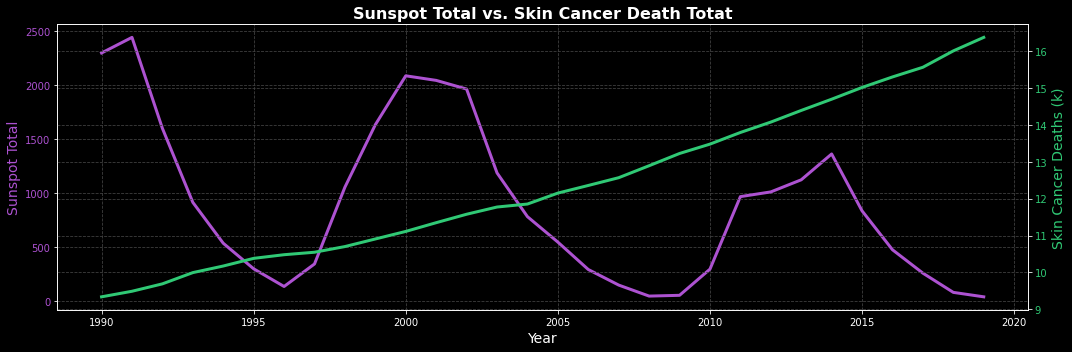

In [36]:
plot_data = final_df[final_df['COUNTRY_ENTITY']=='United States'][['YEAR','SKIN_CANCER_DEATHS','SUNSPOT_COUNT']].groupby('YEAR').sum()

plt.figure(figsize=(15, 5))
plt.xlabel('Year')
ax = plt.gca()  # create axis object for plot
ax2 = ax.twinx()  # synchronize 2nd axis

ax.plot(plot_data.index.values,
        plot_data["SUNSPOT_COUNT"], c='#ad52d1', label='Solar Cycle')
ax.set_ylabel('Sunspot Total', c='#ad52d1')
ax.tick_params(axis='y', labelcolor='#ad52d1')

ax2.plot(plot_data.index.values,
         plot_data['SKIN_CANCER_DEATHS']/1000, c='#30c975', label='Skin Cancer Deaths')
ax2.set_ylabel('Skin Cancer Deaths (k)', c='#30c975')
ax2.tick_params(axis='y', labelcolor='#30c975')

plt.title('Sunspot Total vs. Skin Cancer Death Totat')
plt.show()


<br>

***

# <span style="color:#bce35b">References</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

<u>Cancer Death Rates</u><br>
Bahadir Umut Iscimen. (2019). Cancer Death Rates in the World 1990-2019. Kaggle.com. https://www.kaggle.com/datasets/bahadirumutiscimen/cancer-death-rates-in-the-world-19902019?select=total-cancer-deaths-by-type.csv


<br><u>Sunshine Duration by Country/City</u><br>
Wikipedia Contributors. (2022, March 14). List of cities by sunshine duration. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration


<br><u>Historical Solar Cycles</u><br>
Solar Cycle Progression | NOAA / NWS Space Weather Prediction Center. (2022). Noaa.gov. https://www.swpc.noaa.gov/products/solar-cycle-progression
